In [9]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [10]:
# I/O Func
BASE_PATH = Path(f'/kaggle/working')

def adjusting_price(price, key: str):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[f"CumulativeAdjustmentFactor{key}"] * df[key]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def adjusting_volume(price, key = "Volume"):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[key] / df[f"CumulativeAdjustmentFactor{key}"]  
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def read_prices(dir_name: str, securities_code: int = None):
    """[Important: the dateset of 2020/10/1 is lost because of system failer in JPX, see: https://www.jpx.co.jp/corporate/news/news-releases/0060/20201019-01.html]
    
    """
    base_path = Path(f'../input/jpx-tokyo-stock-exchange-prediction/{dir_name}')
    df = pd.read_csv(base_path / 'stock_prices.csv')
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")
    df = df[df['Open'].notna()]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_stock_list(securities_code: int = None, only_universe: bool = True):
    df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
    df.loc[: ,"EffectiveDate"] = pd.to_datetime(df.loc[: ,"EffectiveDate"], format="%Y%m%d")
    if only_universe:
        df = df[df['Universe0']]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_train_data_by_price(securities_code: int = None, with_supplemental: bool = True):
    """[The train base is price dataset, the other data are joined to prices DF by left join]
    
    """
    def merge_data(prices, stock_list):
        base_df = prices.copy()
        _stock_list = stock_list.copy()
        _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
        base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")
        return base_df
    
    # origin
    df = merge_data(prices=read_prices(dir_name="train_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
    
    # supplyment
    if with_supplemental:
        supplemental_df = merge_data(prices=read_prices(dir_name="supplemental_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
        df = pd.concat([df, supplemental_df]).reset_index(drop=True)
        
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def write_df(df, filename):
    df.to_csv(BASE_PATH / f'{filename}.csv',index = False)

In [11]:
train_df = read_train_data_by_price()
train_df

num_leaves, val_score: 0.024645:  90%|######### | 18/20 [1:01:27<06:49, 204.87s/it]


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,CumulativeAdjustmentFactorClose,AdjustedClose,CumulativeAdjustmentFactorOpen,AdjustedOpen,CumulativeAdjustmentFactorHigh,AdjustedHigh,CumulativeAdjustmentFactorLow,AdjustedLow,CumulativeAdjustmentFactorVolume,AdjustedVolume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,1.0,2742.0,1.0,2734.0,1.0,2755.0,1.0,2730.0,1.0,31400.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,...,1.0,2738.0,1.0,2743.0,1.0,2747.0,1.0,2735.0,1.0,17900.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,...,1.0,2740.0,1.0,2734.0,1.0,2744.0,1.0,2720.0,1.0,19900.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,...,1.0,2748.0,1.0,2745.0,1.0,2754.0,1.0,2735.0,1.0,24200.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,...,1.0,2745.0,1.0,2748.0,1.0,2752.0,1.0,2737.0,1.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,NaN,...,1.0,727.0,1.0,725.0,1.0,729.0,1.0,719.0,1.0,116400.0
2436635,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,NaN,...,1.0,721.0,1.0,719.0,1.0,723.0,1.0,711.0,1.0,225500.0
2436636,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,NaN,...,1.0,719.0,1.0,709.0,1.0,725.0,1.0,708.0,1.0,195600.0
2436637,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,NaN,...,1.0,733.0,1.0,725.0,1.0,738.0,1.0,724.0,1.0,170500.0


# Featrue

In [12]:
def cal_moving_average(key:str, periods):
    def func(df):
        for period in periods:
            col = f"MovingAverage{key}{period}"
            col_gap = f"{col}GapPercent"
            df[col] = df[key].rolling(period, min_periods=1).mean()
            df[col_gap] = (df[key] / df[col]) * 100.0
        return df
    return func

def cal_changing_ration(key:str, periods):
    def func(df):
        for period in periods:
            col = f"ChangingRatio{key}{period}"
            df[col] = df[key].pct_change(period) * 100
        return df
    return func

def cal_historical_vix(key: str, periods):
    def func(df):
        for period in periods:
            col = f"HistoricalVIX{key}{period}"
            df[col] = np.log(df[key]).diff().rolling(period).std()
        return df
    return func

def add_columns_per_code(df, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    df = df.sort_values(["SecuritiesCode", "Date"])
    df = df.groupby("SecuritiesCode").apply(func)
    df = df.reset_index(drop=True)
    return df

def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

def generate_features(df):
    base_df = df.copy()
    prev_column_names = base_df.columns
    periods = [5, 25, 75]
    functions = [
        cal_moving_average("AdjustedClose", periods),
        cal_moving_average("AdjustedOpen", periods),
        cal_moving_average("AdjustedHigh", periods),
        cal_moving_average("AdjustedLow", periods),
        cal_moving_average("AdjustedVolume", periods),
        cal_changing_ration("AdjustedClose", periods),
        cal_changing_ration("AdjustedOpen", periods),
        cal_changing_ration("AdjustedHigh", periods),
        cal_changing_ration("AdjustedLow", periods),
        cal_changing_ration("AdjustedVolume", periods),
        cal_historical_vix("AdjustedClose", periods),
        cal_historical_vix("AdjustedOpen", periods),
        cal_historical_vix("AdjustedHigh", periods),
        cal_historical_vix("AdjustedLow", periods),
        cal_historical_vix("AdjustedVolume", periods)
    ]
    
    base_df = add_columns_per_code(base_df, functions)
    base_df = add_columns_per_day(base_df)
    
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    #feats = feats[feats["HistoricalVIXAdjustedClose75"] != 0]
    return base_df, add_column_names

def select_features(feature_df, add_column_names, is_train):
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    numerical_cols = sorted(add_column_names)
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    label_col = ['Target']
    feat_cols = numerical_cols + categorical_cols
    feature_df = feature_df[base_cols + feat_cols + label_col]
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')
    if is_train:
        feature_df.dropna(inplace=True)
    else:
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    return feature_df, feat_cols, label_col

def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## 特徴量生成
    feature_df, add_column_names = generate_features(feature_df)
    
    ## 特徴量選択
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    return feature_df, feat_cols, label_col

feature_df, feat_cols, label_col = preprocessor(train_df)

# modelの結果をもとにfeat_colsを上書き
feat_cols = ['33SectorCode', 'ChangingRatioAdjustedVolume25', 'diff_rate2', 'MovingAverageAdjustedHigh5GapPercent', 'MovingAverageAdjustedOpen5GapPercent', 'HistoricalVIXAdjustedLow5', 'MovingAverageAdjustedClose5GapPercent', 'HistoricalVIXAdjustedOpen5', 'MovingAverageAdjustedLow25GapPercent', 'ChangingRatioAdjustedVolume5', 'HistoricalVIXAdjustedOpen75', 'HistoricalVIXAdjustedVolume5', 'MovingAverageAdjustedVolume25GapPercent', 'diff_rate1', 'ChangingRatioAdjustedHigh5', 'ChangingRatioAdjustedOpen25', 'HistoricalVIXAdjustedOpen25', 'MovingAverageAdjustedClose25GapPercent', 'MovingAverageAdjustedVolume75GapPercent', 'ChangingRatioAdjustedLow25', 'ChangingRatioAdjustedLow5', 'HistoricalVIXAdjustedHigh75', 'MovingAverageAdjustedLow5GapPercent', 'ChangingRatioAdjustedClose75', 'MovingAverageAdjustedClose75', 'MovingAverageAdjustedClose75GapPercent', 'HistoricalVIXAdjustedVolume75']
feat_cols

['33SectorCode',
 'ChangingRatioAdjustedVolume25',
 'diff_rate2',
 'MovingAverageAdjustedHigh5GapPercent',
 'MovingAverageAdjustedOpen5GapPercent',
 'HistoricalVIXAdjustedLow5',
 'MovingAverageAdjustedClose5GapPercent',
 'HistoricalVIXAdjustedOpen5',
 'MovingAverageAdjustedLow25GapPercent',
 'ChangingRatioAdjustedVolume5',
 'HistoricalVIXAdjustedOpen75',
 'HistoricalVIXAdjustedVolume5',
 'MovingAverageAdjustedVolume25GapPercent',
 'MovingAverageAdjustedVolume5',
 'diff_rate1',
 'ChangingRatioAdjustedHigh5',
 'ChangingRatioAdjustedOpen25',
 'HistoricalVIXAdjustedOpen25',
 'MovingAverageAdjustedClose25GapPercent',
 'MovingAverageAdjustedVolume75GapPercent',
 'ChangingRatioAdjustedLow25',
 'ChangingRatioAdjustedLow5',
 'HistoricalVIXAdjustedHigh75',
 'MovingAverageAdjustedLow5GapPercent',
 'ChangingRatioAdjustedClose75',
 'MovingAverageAdjustedClose5',
 'MovingAverageAdjustedClose75',
 'MovingAverageAdjustedClose75GapPercent',
 'HistoricalVIXAdjustedVolume75']

# Learning

In [13]:
# 予測値を降順に並べて順位番号を振る関数
# 言い換えると、目的変数から提出用項目を導出する関数
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

# 予測用のデータフレームと、予測結果をもとに、スコアを計算する関数
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb

# 学習を実行する関数
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022):
    scores = []
    models = []
    params = []
    i = 0
    for param in fold_params:
        ################################
        # データ準備
        ################################
        train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
        valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

        X_train = train[feat_cols]
        y_train = train[label_col]
        X_valid = valid[feat_cols]
        y_valid = valid[label_col]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        ################################
        # 学習
        ################################
        params = {
            'task': 'train',                   # 学習
            'boosting_type': 'gbdt',           # GBDT
            'objective': 'regression',         # 回帰
            'metric': 'rmse',                  # 損失（誤差）
            'learning_rate': 0.01,             # 学習率
            'lambda_l1': 0.5,                  # L1正則化項の係数
            'lambda_l2': 0.5,                  # L2正則化項の係数
            'num_leaves': 10,                  # 最大葉枚数
            'feature_fraction': 0.5,           # ランダムに抽出される列の割合
            'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
            'bagging_freq': 5,                 # バギング実施頻度
            'min_child_samples': 10,           # 葉に含まれる最小データ数
            'seed': seed                       # シード値
        } 
 
        lgb_results = {}                       
        model = lgb.train( 
            params,                            # ハイパーパラメータ
            lgb_train,                         # 訓練データ
            valid_sets=[lgb_train, lgb_valid], # 検証データ
            valid_names=['Train', 'Valid'],    # データセット名前
            num_boost_round=2000,              # 計算回数
            early_stopping_rounds=100,         # 計算打ち切り設定
            evals_result=lgb_results,          # 学習の履歴
            verbose_eval=100,                  # 学習過程の表示サイクル
        )  

        ################################
        # 結果描画
        ################################
        fig = plt.figure(figsize=(10, 4))

        # loss
        plt.subplot(1,2,1)
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Valid']['rmse']   
        plt.xlabel('Iteration')
        plt.ylabel('logloss')
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='valid loss')
        plt.legend()

        # feature importance
        plt.subplot(1,2,2)
        importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
        write_df(importance, f"importance_{i}")
        sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

        plt.tight_layout()
        plt.show()

        ################################
        # 評価
        ################################
        # 推論
        pred =  model.predict(X_valid, num_iteration=model.best_iteration)
        # 評価
        score = evaluator(valid, pred)

        scores.append(score)
        models.append(model)
        # save model
        model.save_model(f'{BASE_PATH} / model_{i}.txt')
        i = i + 1
        # model = lightgbm.Booster(model_file='lgbr_base.txt')

    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

[I 2022-04-21 23:43:03,065] A new study created in memory with name: no-name-e48f430e-7f26-408a-b9b1-f351012c30be
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.024645:  14%|#4        | 1/7 [00:04<00:25,  4.20s/it]

[100]	Train's rmse: 0.021421	Valid's rmse: 0.024666
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

feature_fraction, val_score: 0.024645:  29%|##8       | 2/7 [00:08<00:20,  4.04s/it]

[100]	Train's rmse: 0.021422	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction, val_score: 0.024645:  43%|####2     | 3/7 [00:11<00:15,  3.79s/it]

[100]	Train's rmse: 0.0214265	Valid's rmse: 0.0246637
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  57%|#####7    | 4/7 [00:15<00:11,  3.74s/it]

[100]	Train's rmse: 0.0214247	Valid's rmse: 0.0246661
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  71%|#######1  | 5/7 [00:19<00:07,  3.94s/it]

[100]	Train's rmse: 0.0214234	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  86%|########5 | 6/7 [00:23<00:03,  3.88s/it]

[100]	Train's rmse: 0.0214215	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645: 100%|##########| 7/7 [00:27<00:00,  3.89s/it]


[100]	Train's rmse: 0.0214213	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246448


num_leaves, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.024645:   5%|5         | 1/20 [00:05<01:48,  5.70s/it]

[100]	Train's rmse: 0.021365	Valid's rmse: 0.0246663
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  10%|#         | 2/20 [00:09<01:23,  4.64s/it]

[100]	Train's rmse: 0.0214137	Valid's rmse: 0.0246661
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  15%|#5        | 3/20 [00:18<01:51,  6.53s/it]

[100]	Train's rmse: 0.0212581	Valid's rmse: 0.0246741
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214567	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  20%|##        | 4/20 [00:24<01:41,  6.35s/it]

[100]	Train's rmse: 0.0213859	Valid's rmse: 0.0246666
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214581	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  25%|##5       | 5/20 [00:33<01:51,  7.42s/it]

[100]	Train's rmse: 0.021241	Valid's rmse: 0.0246723
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214565	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  30%|###       | 6/20 [00:40<01:38,  7.03s/it]

[100]	Train's rmse: 0.0213476	Valid's rmse: 0.0246692
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214577	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  35%|###5      | 7/20 [00:47<01:34,  7.27s/it]

[100]	Train's rmse: 0.0212888	Valid's rmse: 0.0246706
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214571	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  40%|####      | 8/20 [00:56<01:33,  7.79s/it]

[100]	Train's rmse: 0.0212776	Valid's rmse: 0.0246717
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214569	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  45%|####5     | 9/20 [01:05<01:28,  8.00s/it]

[100]	Train's rmse: 0.0212618	Valid's rmse: 0.0246729
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214568	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  50%|#####     | 10/20 [01:11<01:15,  7.58s/it]

[100]	Train's rmse: 0.0213359	Valid's rmse: 0.0246695
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214576	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  55%|#####5    | 11/20 [01:18<01:06,  7.39s/it]

[100]	Train's rmse: 0.0213178	Valid's rmse: 0.0246708
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  60%|######    | 12/20 [01:21<00:48,  6.04s/it]

[100]	Train's rmse: 0.02144	Valid's rmse: 0.0246639
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

num_leaves, val_score: 0.024645:  65%|######5   | 13/20 [01:28<00:43,  6.19s/it]

[100]	Train's rmse: 0.0213657	Valid's rmse: 0.0246671
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  70%|#######   | 14/20 [01:34<00:36,  6.15s/it]

[100]	Train's rmse: 0.0213552	Valid's rmse: 0.0246688
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  75%|#######5  | 15/20 [01:39<00:29,  5.94s/it]

[100]	Train's rmse: 0.0213696	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  80%|########  | 16/20 [01:46<00:25,  6.26s/it]

[100]	Train's rmse: 0.0213178	Valid's rmse: 0.0246708
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  85%|########5 | 17/20 [01:54<00:20,  6.70s/it]

[100]	Train's rmse: 0.021302	Valid's rmse: 0.0246718
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214572	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  90%|######### | 18/20 [02:02<00:14,  7.01s/it]

[100]	Train's rmse: 0.0213368	Valid's rmse: 0.0246694
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214576	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  95%|#########5| 19/20 [02:07<00:06,  6.45s/it]

[100]	Train's rmse: 0.0213833	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214581	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645: 100%|##########| 20/20 [02:14<00:00,  6.72s/it]


[100]	Train's rmse: 0.0213193	Valid's rmse: 0.0246699
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214574	Valid's rmse: 0.0246449


bagging, val_score: 0.024645:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.024645:  10%|#         | 1/10 [00:05<00:49,  5.53s/it]

[100]	Train's rmse: 0.0213668	Valid's rmse: 0.0246699
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  20%|##        | 2/10 [00:11<00:46,  5.85s/it]

[100]	Train's rmse: 0.0213629	Valid's rmse: 0.0246714
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  30%|###       | 3/10 [00:17<00:42,  6.06s/it]

[100]	Train's rmse: 0.0213707	Valid's rmse: 0.0246696
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214581	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  40%|####      | 4/10 [00:23<00:35,  5.91s/it]

[100]	Train's rmse: 0.0213636	Valid's rmse: 0.0246704
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  50%|#####     | 5/10 [00:29<00:28,  5.80s/it]

[100]	Train's rmse: 0.0213624	Valid's rmse: 0.0246705
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  60%|######    | 6/10 [00:35<00:23,  5.93s/it]

[100]	Train's rmse: 0.0213632	Valid's rmse: 0.0246712
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  70%|#######   | 7/10 [00:41<00:17,  5.94s/it]

[100]	Train's rmse: 0.0213636	Valid's rmse: 0.0246704
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  80%|########  | 8/10 [00:48<00:12,  6.26s/it]

[100]	Train's rmse: 0.0213638	Valid's rmse: 0.0246715
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  90%|######### | 9/10 [00:54<00:06,  6.16s/it]

[100]	Train's rmse: 0.0213575	Valid's rmse: 0.0246709
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645: 100%|##########| 10/10 [01:00<00:00,  6.01s/it]


[100]	Train's rmse: 0.021364	Valid's rmse: 0.024669
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246447


feature_fraction_stage2, val_score: 0.024645:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.024645:  17%|#6        | 1/6 [00:05<00:28,  5.70s/it]

[100]	Train's rmse: 0.0213678	Valid's rmse: 0.0246676
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction_stage2, val_score: 0.024645:  33%|###3      | 2/6 [00:11<00:22,  5.56s/it]

[100]	Train's rmse: 0.0213692	Valid's rmse: 0.024668
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

feature_fraction_stage2, val_score: 0.024645:  50%|#####     | 3/6 [00:16<00:17,  5.67s/it]

[100]	Train's rmse: 0.0213657	Valid's rmse: 0.0246671
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  67%|######6   | 4/6 [00:23<00:12,  6.04s/it]

[100]	Train's rmse: 0.0213651	Valid's rmse: 0.0246672
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  83%|########3 | 5/6 [00:29<00:05,  5.98s/it]

[100]	Train's rmse: 0.0213644	Valid's rmse: 0.0246676
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645: 100%|##########| 6/6 [00:35<00:00,  5.89s/it]


[100]	Train's rmse: 0.0213635	Valid's rmse: 0.0246694
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246449


regularization_factors, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.024645:   5%|5         | 1/20 [00:04<01:33,  4.94s/it]

[100]	Train's rmse: 0.0213422	Valid's rmse: 0.0246687
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  10%|#         | 2/20 [00:09<01:26,  4.83s/it]

[100]	Train's rmse: 0.0213424	Valid's rmse: 0.0246685
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  15%|#5        | 3/20 [00:16<01:38,  5.78s/it]

[100]	Train's rmse: 0.0214012	Valid's rmse: 0.0246621
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214583	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  20%|##        | 4/20 [00:21<01:25,  5.37s/it]

[100]	Train's rmse: 0.0213423	Valid's rmse: 0.0246687
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  25%|##5       | 5/20 [00:27<01:24,  5.65s/it]

[100]	Train's rmse: 0.0213949	Valid's rmse: 0.0246645
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214582	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  30%|###       | 6/20 [00:32<01:14,  5.35s/it]

[100]	Train's rmse: 0.0213436	Valid's rmse: 0.0246682
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  35%|###5      | 7/20 [00:37<01:07,  5.21s/it]

[100]	Train's rmse: 0.0213422	Valid's rmse: 0.0246687
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  40%|####      | 8/20 [00:41<01:00,  5.04s/it]

[100]	Train's rmse: 0.0213423	Valid's rmse: 0.0246692
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  45%|####5     | 9/20 [00:46<00:54,  4.98s/it]

[100]	Train's rmse: 0.0213448	Valid's rmse: 0.0246707
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214577	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  50%|#####     | 10/20 [00:51<00:50,  5.06s/it]

[100]	Train's rmse: 0.021347	Valid's rmse: 0.0246671
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

regularization_factors, val_score: 0.024645:  55%|#####5    | 11/20 [00:56<00:44,  4.98s/it]

[100]	Train's rmse: 0.0213423	Valid's rmse: 0.0246684
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  60%|######    | 12/20 [01:02<00:42,  5.36s/it]

[100]	Train's rmse: 0.0214196	Valid's rmse: 0.0246596
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  65%|######5   | 13/20 [01:08<00:37,  5.37s/it]

[100]	Train's rmse: 0.0213583	Valid's rmse: 0.024669
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024644:  70%|#######   | 14/20 [01:14<00:34,  5.68s/it]

[100]	Train's rmse: 0.0214276	Valid's rmse: 0.0246584
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  75%|#######5  | 15/20 [01:21<00:30,  6.14s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	Train's rmse: 0.0214232	Valid's rmse: 0.0246586
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[Li

regularization_factors, val_score: 0.024644:  80%|########  | 16/20 [01:26<00:22,  5.72s/it]

[100]	Train's rmse: 0.0213422	Valid's rmse: 0.0246687
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  85%|########5 | 17/20 [01:31<00:16,  5.51s/it]

[100]	Train's rmse: 0.0213444	Valid's rmse: 0.0246716
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.024645
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024644:  90%|######### | 18/20 [01:37<00:10,  5.44s/it]

[100]	Train's rmse: 0.0213554	Valid's rmse: 0.0246711
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214579	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644:  95%|#########5| 19/20 [01:43<00:05,  5.77s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024644: 100%|##########| 20/20 [01:48<00:00,  5.42s/it]


[100]	Train's rmse: 0.0213422	Valid's rmse: 0.0246687
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246451


min_data_in_leaf, val_score: 0.024644:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

min_data_in_leaf, val_score: 0.024644:  20%|##        | 1/5 [00:07<00:29,  7.38s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024644:  40%|####      | 2/5 [00:13<00:20,  6.79s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

min_data_in_leaf, val_score: 0.024644:  60%|######    | 3/5 [00:20<00:13,  6.62s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until valida

min_data_in_leaf, val_score: 0.024644:  80%|########  | 4/5 [00:26<00:06,  6.50s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7173
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation sco

min_data_in_leaf, val_score: 0.024644: 100%|##########| 5/5 [00:32<00:00,  6.57s/it]

[100]	Train's rmse: 0.0214284	Valid's rmse: 0.0246581
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246445


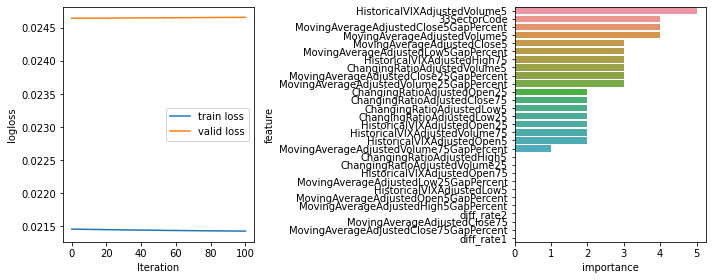

[LightGBM] [Fatal] Model file /kaggle/working / model_0.txt is not available for writes


LightGBMError: Model file /kaggle/working / model_0.txt is not available for writes

In [14]:
# 2020-12-23よりも前のデータは証券コードが2000個すべて揃っていないため、これ以降のデータのみを使う。
# (学習用データの開始日、学習用データの終了日＝検証用データの開始日、検証用データの終了日)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params)